In [1]:
import tskit
import pyslim
import os
import numpy as np
from scipy.linalg import expm
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kde
import pandas as pd

In [2]:
dir_source = '/n/holyscratch01/mallet_lab/txiong/Research/2022_EntropyAncestry/simulation.slim/neutralWF'

seed = '2092003974471'

N = 2000
t = 2000

os.chdir(dir_source+'/N.{}.t.{}'.format(N,t)+'/slim_seed'+seed)

In [3]:
# partition ancestor to K sources
def partition_ancestors(P,ind_ancestor):
    
    K = len(P)
    
    N = len(ind_ancestor)
    
    N_k = []
    
    for k in np.arange(0,K-1):
        
        N_k.append(int(np.round(N*P[k])))
        
    N_k.append(int(N-np.sum(N_k)))
    
    groups = np.array([])
    
    for k in np.arange(0,K):
        
        groups = np.concatenate([groups,np.zeros(N_k[k])+k])
        
    groups = np.random.permutation(groups)
            
    return groups.astype(int)

# sample nodes from the current generation
def sample_current_nodes(ts,n_ind=1):
    
    alive_inds = pyslim.individuals_alive_at(ts, 0)
    keep_indivs = np.random.choice(alive_inds, n_ind, replace=False)
    keep_nodes = []
    for i in keep_indivs:
          keep_nodes.extend(ts.individual(i).nodes)
            
    return keep_nodes

# get ancestry states for each haplotype
def get_ancestry_for_haplotypes(ts,
                                interval,
                                anc_ancestral_haplotype,
                                node_ancestral_haplotype
                                ):
    
    L = int(ts.sequence_length)
    l_left,l_right = interval #l_left: inclusive; l_right: exclusive
    
    ind_current = pyslim.individuals_alive_at(ts, 0)   
    hap_current = np.concatenate([ts.individual(i).nodes for i in ind_current])
    
    anc_blocks = []
    
    for h in hap_current:
        
        ts_singleton = ts.simplify([h],keep_input_roots=True)
        
        breakpoints = ts_singleton.breakpoints([0])
        
        roots = np.array([t.root for t in ts_singleton.trees()])
        
        # If roots is not a contiguous series of integer from 0:
        # roots_index = np.array([np.where(r==node_ancestral_haplotype)[0][0] for r in roots])
        
        # If roots is a contiguous series of integer from 0:
        # roots_index = roots
        
        roots_slim_id = [ts_singleton.node(root).metadata['slim_id'] for root in roots] # slim haplotype id
        
        ancestry = anc_ancestral_haplotype[roots_slim_id]
        
        anc_block = np.zeros(l_right-l_left)
        
        breakpoints_idx = np.where((breakpoints >= l_left) & (breakpoints < l_right))[0]
        
        if len(breakpoints_idx)==0:
            
            anc_block[:] = ancestry[np.where(breakpoints < l_left)[0][-1]]
            
        else:
        
            bp_included = (breakpoints[breakpoints_idx]).astype(int)
            bp_included = np.concatenate([bp_included,[l_right+1]]) # append a dummy right element
            anc_included = ancestry[breakpoints_idx]
                        
            anc_block[0 : bp_included[0] - l_left] = ancestry[breakpoints_idx[0]-1]

            for i in range(len(breakpoints_idx)):
                                
                anc_block[bp_included[i] - l_left : np.minimum(bp_included[i+1] - l_left,l_right-l_left)] = anc_included[i]

        anc_blocks.append(anc_block)
        
        
    return  anc_blocks

def anc_categorical_to_vectorized(anc_categorical,K):
    
    # K: number of distinct categories
    
    # convert categorical haplotype ancestry [0,1,2,1,0]
    # to vectors
    
    if len(anc_categorical.shape) == 2:
        
        n,y = anc_categorical.shape
        
        anc_vectorized = []
        for i in range(n):
            anc_vectorized.append([anc_categorical[i] == k for k in range(K)])
        
    else:
        
        anc_vectorized = [anc_categorical == k for k in range(K)]
        
    return np.array(anc_vectorized) * 1

def anc_categorical_to_vectorized_diploid(anc_categorical,K):
    
    # K: number of distinct categories
    
    # convert pairs of categorical haplotype ancestry [[0,1,2,1,0],[0,1,2,2,1]]
    # to vectors using the spherical representation (Bloch's sphere)
    
    # variable "anc_categorical" must be numpy arrays of pairs of haplotypes,
    # so it should have two rows. 2*i and 2*i+1 rows are considered a pair, where i=0,1,2,...,n/2
        
    n,l = anc_categorical.shape
    
    anc_vectorized = []
    
    for i in range(int(n/2)):
        
        hap1,hap2 = anc_categorical[int(2*i):int(2*i+2)]
                
        y = []

        for k in np.arange(0,K):

            pk_sqrt = np.sqrt(((hap1 == k)*1 + (hap2 == k)*1)/2)

            y.append(pk_sqrt)
        
        anc_vectorized.append(y)
            
        
    return np.array(anc_vectorized)
    

In [4]:
def Sb2_haplotypes(block_ancestry):
    
    # block_ancestry is an numpy array of ancestry states along haplotype blocoks
    
    n = block_ancestry.shape[0]
    
    cij = np.array([])
    
    # only doing for i != j
    for i in np.arange(0,n-1):
        for j in np.arange(i+1,n):
            cij = np.append(cij,np.mean(block_ancestry[i] == block_ancestry[j]))
            
    Sb2 = 1 - (np.sum((cij)**2)*2 + n) / (n**2)

    return Sb2

def Sw2_haplotypes(vectorized_ancestry):
    
    # input must be numpy arrays of the form:
    
    #    k=0    k=1
    # [[[0,1],[1,0]], # haplotype 1
    #  [[1,1],[0,0]], # haplotype 2
    #  [[1,0],[0,1]]] # haplotype 3
    
    # n * K * L dimensional arrays
    
    n = vectorized_ancestry.shape[0]
    K = vectorized_ancestry.shape[1]
    L = vectorized_ancestry.shape[2]
    M = n*K
    
    anc = np.concatenate(vectorized_ancestry)
    
    # case: i != j
    
    aij = []
    
    for i in np.arange(0,M-1):
        for j in np.arange(i+1,M):
            aij.append(np.sum(anc[i]*anc[j]))
            
    aij = np.array(aij)
            
    aii = [np.sum(anc[i]) for i in range(M)]
    
    aii = np.array(aii)
    
    return 1 - (2*(np.sum(aij**2)) + np.sum(aii**2))/((L*n)**2)

In [5]:
def Sb2_diplotypes(vectorized_ancestry):
    
    # input must be numpy arrays of the form:
    
    #    k=0     k=1              k=2
    # [[[0,1,0],[1,0,np.sqrt(2)],[0,0,np.sqrt(2)]], # diplotype 1
    #  [[1,1,0],[0,0,0],         [0,0,1]],          # diplotype 2
    #  [[1,0,1],[0,1,0],         [0,0,0]]]          # diplotype 3    
    
    
    n = vectorized_ancestry.shape[0]
    
    cij = np.array([])
    
    # only doing for i != j
    for i in np.arange(0,n-1):
        for j in np.arange(i+1,n):
            
            cij = np.append(cij,np.mean((vectorized_ancestry[i] * vectorized_ancestry[j]).sum(axis=0)))
            
    Sb2 = 1 - (np.sum((cij)**2)*2 + n) / (n**2)

    return Sb2

def Sw2_diplotypes(vectorized_ancestry):
    
    # input must be numpy arrays of the form:
    
    #    k=0     k=1              k=2
    # [[[0,1,0],[1,0,np.sqrt(2)],[0,0,np.sqrt(2)]], # diplotype 1
    #  [[1,1,0],[0,0,0],         [0,0,1]],          # diplotype 2
    #  [[1,0,1],[0,1,0],         [0,0,0]]]          # diplotype 3
    
    # n * K * L dimensional arrays
    
    n = vectorized_ancestry.shape[0]
    K = vectorized_ancestry.shape[1]
    L = vectorized_ancestry.shape[2]
    M = n*K
    
    anc = np.concatenate(vectorized_ancestry)
    
    # case: i != j
    
    aij = []
    
    for i in np.arange(0,M-1):
        for j in np.arange(i+1,M):
            aij.append(np.sum(anc[i]*anc[j]))
            
    aij = np.array(aij)
            
    aii = [np.sum(anc[i]**2) for i in range(M)]
    
    aii = np.array(aii)
    
    return 1 - (2*(np.sum(aij**2)) + np.sum(aii**2))/((L*n)**2)

In [6]:
def prepare_treesequences(filename,P):
    
    # load a tree-sequence file and impose ancestry in founder individuals
    
    # filename: filename of the .trees file
    # P: ancestry contribution in the 0-th generation (e.g., [0.2,0.7,0.1])
    
    ts = tskit.load(filename)
    
    gen = ts.metadata['SLiM']['tick']

    ind_ancestor = pyslim.individuals_alive_at(ts, gen)
    ind_current = pyslim.individuals_alive_at(ts, 0);
    
    # assigning ancestry to first-generation individuals

    anc_ancestor = partition_ancestors(P,ind_ancestor)
    anc_ancestral_haplotype = np.concatenate([[anc_ancestor[i],anc_ancestor[i]] for i in range(len(anc_ancestor))])
    node_ancestral_haplotype = np.concatenate([ts.individual(i).nodes for i in ind_ancestor])
    
    return ts, anc_ancestral_haplotype, node_ancestral_haplotype


def get_entropy_from_treesequences(ts,
                                   P,
                                   anc_ancestral_haplotype,
                                   node_ancestral_haplotype,
                                   interval=[0,10],
                                   n_diploid_ind=1):
    
    # sample from a .trees file and calculate entropy

    
    # n_diploid_ind: number of diploid individuals
    # interval: the interval to calculate entropy
    
    node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
    sts = ts.simplify(node_sample, keep_input_roots=True)
    
    # extract ancestry states for each haplotype block

    block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
    block_ancestry = np.array(block_ancestry)
    
    anc_vectorized = anc_categorical_to_vectorized(block_ancestry,len(P))
    
    Sb2 = Sb2_haplotypes(block_ancestry)
    Sw2 = Sw2_haplotypes(anc_vectorized)
    
    return Sb2,Sw2



### Troubleshooting for haploid $\Delta S$

In [60]:
P = [0.5,0.5] 
gen = 1500
n_diploid_ind = 50
interval = [0,int(1e5)]


ts, anc_ancestral_haplotype,node_ancestral_haplotype = prepare_treesequences(
                    'slim_seed'+seed+'_gen'+str(gen)+'.trees',
                    P)

node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
sts = ts.simplify(node_sample, keep_input_roots=True)


# extract ancestry states for each haplotype block
block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
block_ancestry = np.array(block_ancestry)

## Haploid S: get ΔS and transform block_ancestry

anc_vectorized = anc_categorical_to_vectorized(block_ancestry,len(P))
    
Sb2 = Sb2_haplotypes(block_ancestry)
Sw2 = Sw2_haplotypes(anc_vectorized)
ΔS = Sb2 - Sw2
print(ΔS)

-0.0008315694000000651


In [61]:
# transform block_ancestry

block_ancestry[block_ancestry == 0]=-1
block_ancestry

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [39]:
## PCA on binary ancestry
pca = PCA(n_components=2)
pca.fit(block_ancestry)

PCA(n_components=2)

In [62]:
coord = pca.transform(block_ancestry);

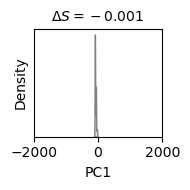

In [63]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(x=coord[:,0], color='gray', fill=True, bw_adjust=1)
plt.xlim(-2000,2000)
plt.xlabel('PC1')
plt.title(r'$\Delta S={}$'.format(ΔS.round(3)),fontsize=10)
plt.yticks([])

fig.tight_layout()   

In [134]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'Delta_S_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

### Troubleshooting for diploid $\Delta S$

In [203]:
P = [0.5,0.5] # initial admixture proportion
gen = 1
n_diploid_ind = 50
interval = [0,int(1e6)]

    
ts, anc_ancestral_haplotype,node_ancestral_haplotype = prepare_treesequences(
                    'slim_seed'+seed+'_gen'+str(gen)+'.trees',
                    P)

node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
sts = ts.simplify(node_sample, keep_input_roots=True)


# extract ancestry states for each haplotype block
block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
block_ancestry = np.array(block_ancestry)
K = len(P)
Y = anc_categorical_to_vectorized_diploid(block_ancestry,K)

Sb2 = Sb2_diplotypes(Y)
Sw2 = Sw2_diplotypes(Y)

ΔS = Sb2-Sw2

print(ΔS)

0.34240000000000037


In [204]:
# transform block_ancestry to numeric diplotypes

block_ancestry[block_ancestry == 0]=-1
block_ancestry_dip = (block_ancestry[np.arange(0,n_diploid_ind*2,2)] 
                        + block_ancestry[np.arange(1,n_diploid_ind*2,2)])/2


In [156]:
## PCA on binary ancestry
pca = PCA(n_components=2)
pca.fit(block_ancestry_dip)

PCA(n_components=2)

In [205]:
coord = pca.transform(block_ancestry_dip);

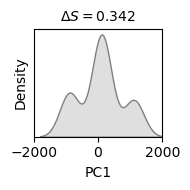

In [206]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(x=coord[:,0], color='gray', fill=True, bw_adjust=1)
plt.xlim(-2000,2000)
plt.xlabel('PC1')
plt.title(r'$\Delta S={}$'.format(ΔS.round(3)),fontsize=10)
plt.yticks([])

fig.tight_layout()  

In [207]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'DiploidUnphased_Delta_S_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

### Troubleshotting for diploid unphased triangular plot

In [38]:
P = [0.5,0.5] # initial admixture proportion
gen = 2000
n_diploid_ind = 50
interval = [0,int(1e6)]

    
ts, anc_ancestral_haplotype,node_ancestral_haplotype = prepare_treesequences(
                    'slim_seed'+seed+'_gen'+str(gen)+'.trees',
                    P)

node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
sts = ts.simplify(node_sample, keep_input_roots=True)


# extract ancestry states for each haplotype block
block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
block_ancestry = np.array(block_ancestry)



In [39]:
# transform block_ancestry to numeric diplotypes

block_ancestry_dip = (block_ancestry[np.arange(0,n_diploid_ind*2,2)] 
                        + block_ancestry[np.arange(1,n_diploid_ind*2,2)])/2

In [40]:
p = block_ancestry_dip.mean(axis=1) # mean ancestry from source '1'

h = ((block_ancestry_dip==0.5)*1).mean(axis=1)

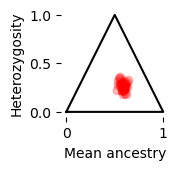

In [41]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
ax.set_xlabel('Mean ancestry')
ax.set_ylabel('Heterozygosity')
ax.plot([0,0.5,1,0],[0,1,0,0],color='black')
ax.scatter(p,h,alpha=0.25,color='red')
ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout() 

In [42]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'TriangularPlot_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

# Analyzing simulated entropy

## 0. Extract $\Delta S$

In [7]:
def get_PCA_fit(gen = 1, P=[0.5,0.5],L = 1e5, n_diploid_ind=50):
    
    P = P
    gen = gen
    n_diploid_ind = 50
    interval = [0,int(L)]


    ts, anc_ancestral_haplotype,node_ancestral_haplotype = prepare_treesequences(
                        'slim_seed'+seed+'_gen'+str(gen)+'.trees',
                        P)

    node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
    sts = ts.simplify(node_sample, keep_input_roots=True)


    # extract ancestry states for each haplotype block
    block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
    block_ancestry = np.array(block_ancestry)
    
    block_ancestry[block_ancestry == 0]=-1
    block_ancestry_dip = (block_ancestry[np.arange(0,n_diploid_ind*2,2)] 
                        + block_ancestry[np.arange(1,n_diploid_ind*2,2)])/2
    
    ## haploid PCA on transformed ancestry
    pca_hap = PCA(n_components=2)
    pca_hap.fit(block_ancestry)
    
    ## diploid PCA on transformed ancestry
    pca_dip = PCA(n_components=2)
    pca_dip.fit(block_ancestry_dip)
    
    return pca_hap,pca_dip    

In [58]:
P = [0.5,0.5] 
L = 1e6
n_diploid_ind = 50

# get pca for haploid and diploid first generation genotypes
pca_hap,pca_dip = get_PCA_fit(gen=1,P=P,L=L,n_diploid_ind=n_diploid_ind)

In [96]:
gen = 2000

interval = [0,int(L)]


ts, anc_ancestral_haplotype,node_ancestral_haplotype = prepare_treesequences(
                    'slim_seed'+seed+'_gen'+str(gen)+'.trees',
                    P)

node_sample = sample_current_nodes(ts,n_ind=n_diploid_ind)
sts = ts.simplify(node_sample, keep_input_roots=True)


# extract ancestry states for each haplotype block
block_ancestry = get_ancestry_for_haplotypes(sts,interval,anc_ancestral_haplotype,node_ancestral_haplotype)
block_ancestry = np.array(block_ancestry)

## Haploid S

Y = anc_categorical_to_vectorized(block_ancestry,len(P))
    
Sb2 = Sb2_haplotypes(block_ancestry)
Sw2 = Sw2_haplotypes(Y)
ΔS_hap = Sb2 - Sw2
print('Haploid $\Delta S$'+': {}'.format(ΔS_hap))


## Diploid S: 

Y = anc_categorical_to_vectorized_diploid(block_ancestry,len(P))

Sb2 = Sb2_diplotypes(Y)
Sw2 = Sw2_diplotypes(Y)
ΔS_dip = Sb2-Sw2

print('Diploid $\Delta S$'+': {}'.format(ΔS_dip))

# transform block_ancestry to numeric diplotypes

block_ancestry[block_ancestry == 0]=-1 # for haploid PCA
block_ancestry_dip = (block_ancestry[np.arange(0,n_diploid_ind*2,2)] 
                        + block_ancestry[np.arange(1,n_diploid_ind*2,2)])/2 # for diploid PCA

# projection on to PC1

coord_hap = pca_hap.transform(block_ancestry);
coord_dip = pca_dip.transform(block_ancestry_dip);

# compute mean ancestry and heterozygosity
# transform back to 0,1 representation
block_ancestry[block_ancestry == -1]=0
block_ancestry_dip = (block_ancestry[np.arange(0,n_diploid_ind*2,2)] 
                        + block_ancestry[np.arange(1,n_diploid_ind*2,2)])/2

p = block_ancestry_dip.mean(axis=1) # mean ancestry from source '1'
h = ((block_ancestry_dip==0.5)*1).mean(axis=1)

Haploid $\Delta S$: -0.19049834230822005
Diploid $\Delta S$: -0.24635604065351746


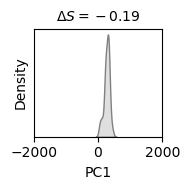

In [97]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(x=coord_hap[:,0], color='gray', fill=True, bw_adjust=1)
plt.xlim(-2000,2000)
plt.xlabel('PC1')
plt.title(r'$\Delta S={}$'.format(ΔS_hap.round(3)),fontsize=10)
plt.yticks([])

fig.tight_layout()

In [98]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'Delta_S_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

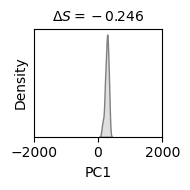

In [99]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(x=coord_dip[:,0], color='gray', fill=True, bw_adjust=1)
plt.xlim(-2000,2000)
plt.xlabel('PC1')
plt.title(r'$\Delta S={}$'.format(ΔS_dip.round(3)),fontsize=10)
plt.yticks([])

fig.tight_layout() 

In [100]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'DiploidUnphased_Delta_S_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

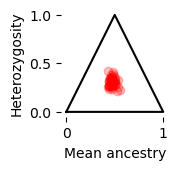

In [101]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
ax.set_xlabel('Mean ancestry')
ax.set_ylabel('Heterozygosity')
ax.plot([0,0.5,1,0],[0,1,0,0],color='black')
ax.scatter(p,h,alpha=0.25,color='red')
ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout() 

In [102]:
dir_output='/n/home00/txiong/Research/2022_EntropyAncestry/DeltaS_PCA'

P_str = ','.join(np.array(P).astype(str))

prefix = 'TriangularPlot_P_{}_Gen_{}_nDiploid_{}_L_{}_nBlocks_1_N_{}_Seed_{}'.format(P_str,gen,n_diploid_ind,interval[1],N,seed)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

## 1. Haplotype analysis

In [2]:
def Generator(N,r):
    # the generator of a two-locus, two-haplotype ARG
    R = 2*N*r
    G1 = np.array([[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,0,0,0,0],
              [R,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [R,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,R,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,R,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,R,R,R,R,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,1,0,0,0,1,0,0,0,0,0],
              [0,0,0,1,1,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,1,R,R,0,0,0,0,0,0],
              [0,0,1,0,1,0,0,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,1,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,1,0,0,0,R,R,0,0,0],
              [1,1,0,0,0,0,0,1,1,0,1,1,0,0,1],
              [0,0,0,0,0,0,0,0,0,1,0,0,1,R,0]])/(2*N)
    G2 = np.diag([-2*R-1,-2*R-1,-R-3,-R-3,-R-3,
                  -R-3,-6,-R-1,-R-1,-3,-R-1,
                  -R-1,-3,-R,-1])/(2*N)
    
    return G1 + G2

def Qb_bar(t,α1,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    Gs = np.array([np.transpose(Generator(N,1-np.exp(-abs(x-y)))) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return np.matmul((expm(t*Gs).mean(axis=0)),α1)[0]

def Qw_bar(t,α2,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    Gs = np.array([np.transpose(Generator(N,1-np.exp(-abs(x-y)))) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return np.matmul((expm(t*Gs).mean(axis=0)),α2)[0]

def qw(t,H0,r,N):
    
    p = (1+2*N*r*np.exp(-t/(2*N)-r*t))/(1+2*N*r) 
    return (1-p)*(1-H0) + p

def qw_bar(t,H0,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    qws = np.array([qw(t,H0,1-np.exp(-abs(x-y)),N) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return qws.mean()

def qc(t,H0,r,N):
    
    p = 1-H0*(np.exp(-t/(2*N)-r*t)+2*N*r)/(1+2*N*r)
    return p

def Qc_bar(t,H0,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    qcs = np.array([qc(t,H0,1-np.exp(-abs(x-y)),N) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return qcs.mean()

def get_simulation_results(N,t,seeds,parameters,dir_parent):
    
    P,nDiploid,L,nResampling = parameters
    
    os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))
    
    P_str = ','.join(P.astype(str))

    # two probability vectors

    H0 = 1 - np.sum(P**2)
    J0 = 1 - np.sum(P**3)

    α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
    α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])
    
    # enumerate over all seeds

    Sw_mean_all = []
    Sw_ste_all = []
    Sb_mean_all = []
    Sb_ste_all = []

    for s in tqdm(seeds):

        Sb = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sb2_P_{}_nDiploid_{}_L_{}_nResampling_{}.npy'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True).item()
        Sw = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sw2_P_{}_nDiploid_{}_L_{}_nResampling_{}.npy'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True).item()

        gen_range = [int((k.split(',')[0]).split('=')[1]) for k in Sb.keys()]

        Sw_mean = np.array([np.mean(Sw['gen={},L={}'.format(gen,L)]) for gen in gen_range])
        Sb_mean = np.array([np.mean(Sb['gen={},L={}'.format(gen,L)]) for gen in gen_range])

        Sw_ste = np.array([np.std(Sw['gen={},L={}'.format(gen,L)])/np.sqrt(np.array(Sw['gen={},L={}'.format(gen,L)]).size) for gen in gen_range])
        Sb_ste = np.array([np.std(Sb['gen={},L={}'.format(gen,L)])/np.sqrt(np.array(Sb['gen={},L={}'.format(gen,L)]).size) for gen in gen_range])

        Sw_mean_all.append(Sw_mean)
        Sb_mean_all.append(Sb_mean)
        Sw_ste_all.append(Sw_ste)
        Sb_ste_all.append(Sb_ste)
    
    
    Sw_mean = np.array(Sw_mean_all).mean(axis=0)
    Sb_mean = np.array(Sb_mean_all).mean(axis=0)

    Sw_ste = np.sqrt((np.array(Sw_ste_all)**2).sum(axis=0)/len(Sw_ste_all))
    Sb_ste = np.sqrt((np.array(Sb_ste_all)**2).sum(axis=0)/len(Sw_ste_all))
    
    
    # calculate theoretical curves from ARG
    
    l = L/1e7

    t_range = np.concatenate([np.arange(1,10,1),np.arange(10,500,10),np.arange(500,t+100,100)])


    Qb_bar_eval = np.array([])
    Qw_bar_eval = np.array([])
    qw_bar_eval = np.array([])

    for t in tqdm(t_range):
        Qb_bar_eval = np.append(Qb_bar_eval,Qb_bar(t,α1,l,N))
        Qw_bar_eval = np.append(Qw_bar_eval,Qw_bar(t,α2,l,N))
        qw_bar_eval = np.append(qw_bar_eval,qw_bar(t,H0,l,N))
    
    n = nDiploid * 2

    E_Sb2 = 1 - (n-1)/n * Qb_bar_eval - 1/n
    E_Sw2 = 1 - (n-1)/n * Qw_bar_eval - 1/n * qw_bar_eval
    
    
    return Sb_mean,Sw_mean,Sb_ste,Sw_ste,E_Sb2,E_Sw2,t_range,gen_range
    

#### Theoretical results only

100%|██████████| 42/42 [00:02<00:00, 20.36it/s]


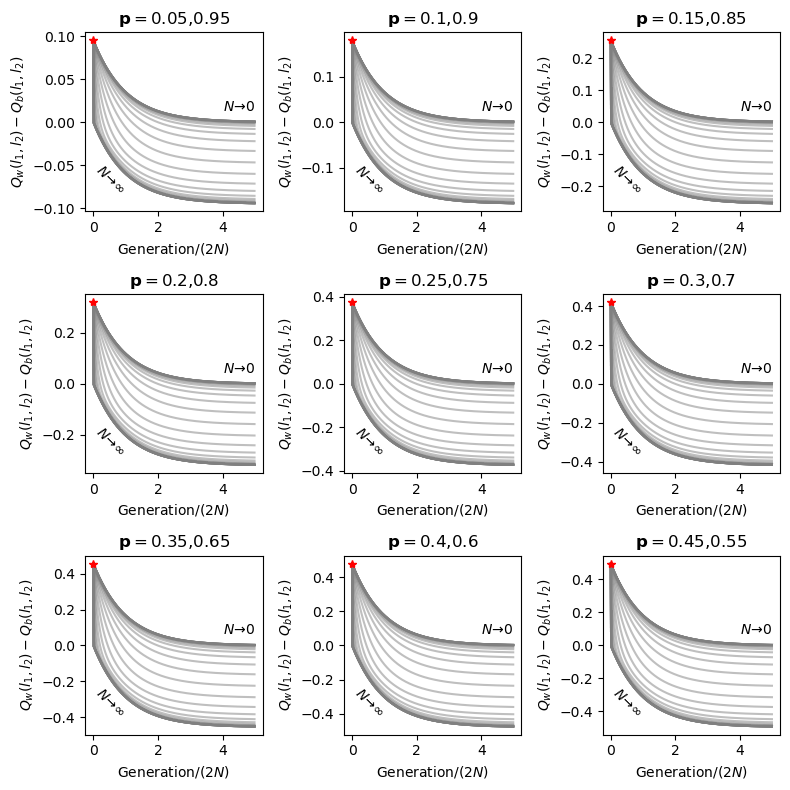

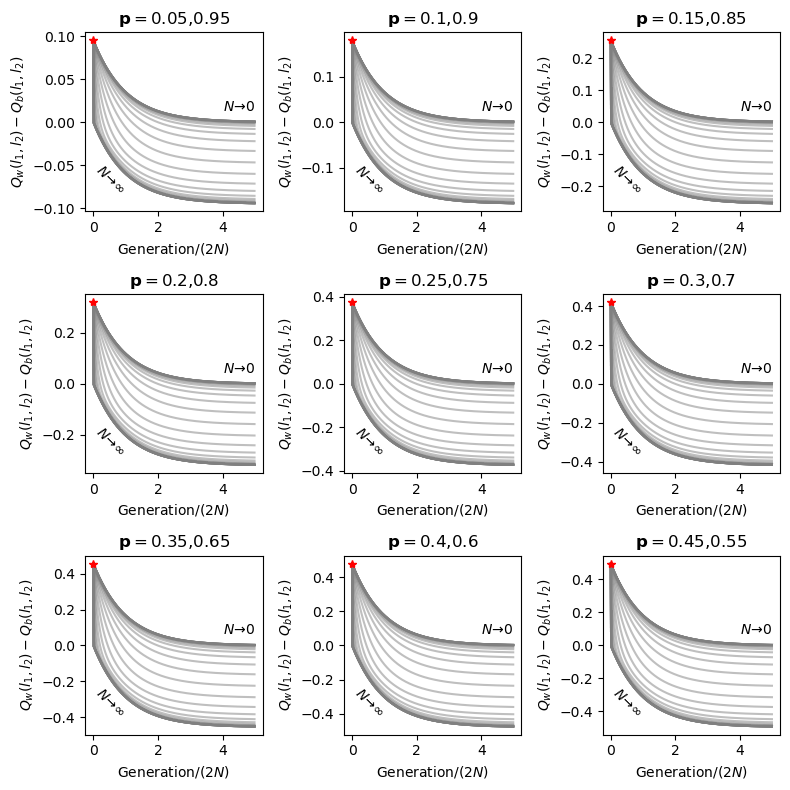

In [127]:
fig,ax=plt.subplots(3,3,figsize=(8,8))

i = 0

for p1 in np.arange(0.05,0.5,0.05).round(2):

    P = np.array([p1,(1-p1).round(2)])

    P_str = ','.join(P.astype(str))

    H0 = 1 - np.sum(P**2)
    J0 = 1 - np.sum(P**3)

    α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
    α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])


    t_range=np.arange(0,5,0.01)
    ρ_range=10**np.arange(-5,5.5,0.25)

    for ρ in tqdm(ρ_range):

        N = 100
        r = ρ/(2*N)

        Z1 = np.array([])
        G_trans = np.transpose(Generator(N,r)*2*N)

        for t in t_range:
            exptGα = np.matmul(expm(t*G_trans),α2-α1)
            Z1 = np.append(Z1,exptGα[0])

        ax[i//3,i-(i//3)*3].plot(t_range,Z1,color='gray',alpha=0.5)

    ax[i//3,i-(i//3)*3].set_title(r'$\mathbf{p}=$'+'{}'.format(P_str))
    ax[i//3,i-(i//3)*3].set_xlabel('Generation'+r'$/(2N)$')
    ax[i//3,i-(i//3)*3].set_ylabel(r'$Q_w(l_1,l_2)-Q_b(l_1,l_2)$')

    ax[i//3,i-(i//3)*3].annotate(r'$N\to\infty$',(0,-H0/2),va='top',rotation=-45)
    ax[i//3,i-(i//3)*3].annotate(r'$N\to0$',(4,H0/10),va='bottom',rotation=-0)

    ax[i//3,i-(i//3)*3].plot([0],[H0],'*',color='red')
    
    i = i+1
    
    
fig.tight_layout()   

fig

In [128]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/ARG_Numerical_Evaluation'

prefix = 'Delta_Qw_Qb_TwoSourcesP'

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

100%|██████████| 42/42 [00:02<00:00, 20.04it/s]


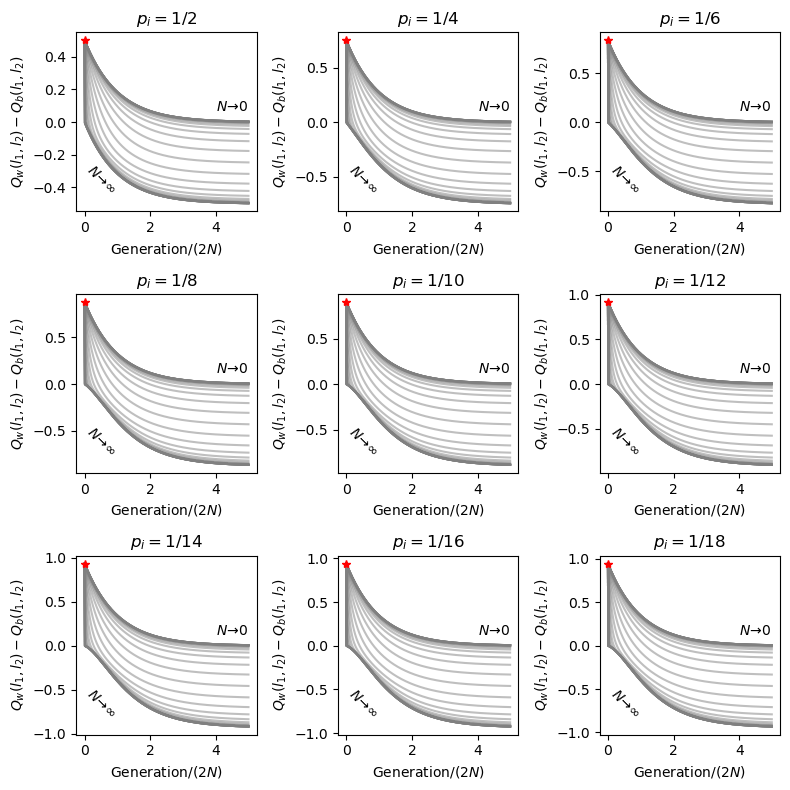

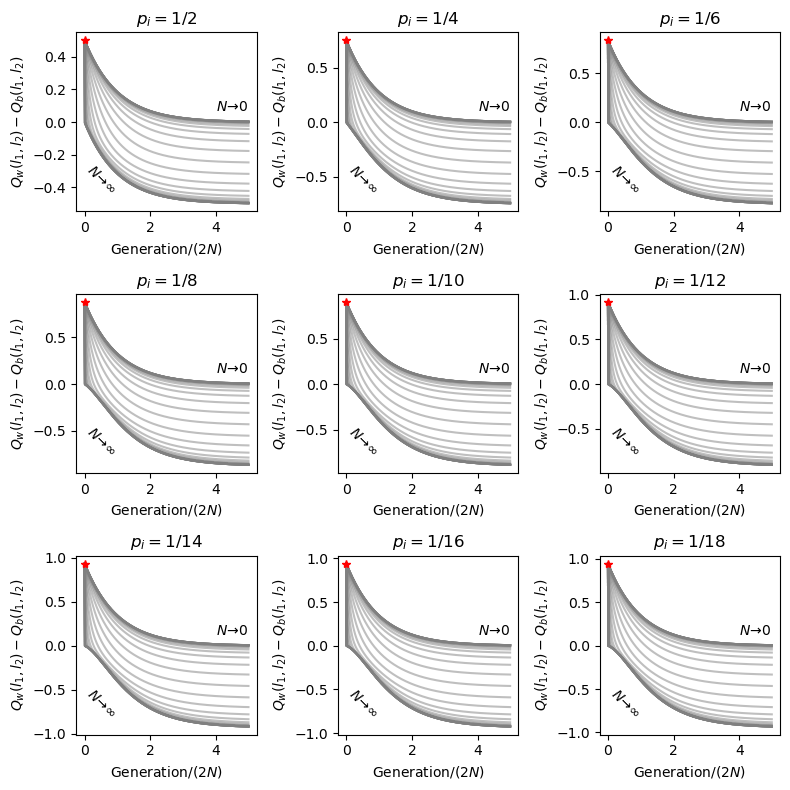

In [124]:
fig,ax=plt.subplots(3,3,figsize=(8,8))

i = 0

for n in np.arange(2,19,2):

    P = np.repeat([1/n],int(n))

    n_str = str(int(n))

    H0 = 1 - np.sum(P**2)
    J0 = 1 - np.sum(P**3)

    α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
    α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])


    t_range=np.arange(0,5,0.01)
    ρ_range=10**np.arange(-5,5.5,0.25)

    for ρ in tqdm(ρ_range):

        N = 100
        r = ρ/(2*N)

        Z1 = np.array([])
        G_trans = np.transpose(Generator(N,r)*2*N)

        for t in t_range:
            exptGα = np.matmul(expm(t*G_trans),α2-α1)
            Z1 = np.append(Z1,exptGα[0])

        ax[i//3,i-(i//3)*3].plot(t_range,Z1,color='gray',alpha=0.5)

    ax[i//3,i-(i//3)*3].set_title(r'$p_i=1/{}$'.format(n_str))
    ax[i//3,i-(i//3)*3].set_xlabel('Generation'+r'$/(2N)$')
    ax[i//3,i-(i//3)*3].set_ylabel(r'$Q_w(l_1,l_2)-Q_b(l_1,l_2)$')

    ax[i//3,i-(i//3)*3].annotate(r'$N\to\infty$',(0,-H0/2),va='top',rotation=-45)
    ax[i//3,i-(i//3)*3].annotate(r'$N\to0$',(4,H0/10),va='bottom',rotation=-0)

    ax[i//3,i-(i//3)*3].plot([0],[H0],'*',color='red')
    
    i = i+1
    
    
fig.tight_layout()   

fig

In [126]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/ARG_Numerical_Evaluation'

prefix = 'Delta_Qw_Qb_MaxEntropyP'

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [46]:
# calculate theoretical curves from ARG

P = np.array([0.5,0.5])
nDiploid = 100
L = 1000000
N = 2000000
t = 2000

l = L/1e7
H0 = 1 - np.sum(P**2)
J0 = 1 - np.sum(P**3)

α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])


t_range = np.concatenate([np.arange(1,10,1),np.arange(10,500,10),np.arange(500,t+100,1000)])


Qb_bar_eval = np.array([])
Qw_bar_eval = np.array([])
qw_bar_eval = np.array([])

for t in tqdm(t_range):
    Qb_bar_eval = np.append(Qb_bar_eval,Qb_bar(t,α1,l,N))
    Qw_bar_eval = np.append(Qw_bar_eval,Qw_bar(t,α2,l,N))
    qw_bar_eval = np.append(qw_bar_eval,qw_bar(t,H0,l,N))

n = nDiploid * 2

E_Sb2 = 1 - (n-1)/n * Qb_bar_eval - 1/n
E_Sw2 = 1 - (n-1)/n * Qw_bar_eval - 1/n * qw_bar_eval

100%|██████████| 60/60 [00:09<00:00,  6.09it/s]


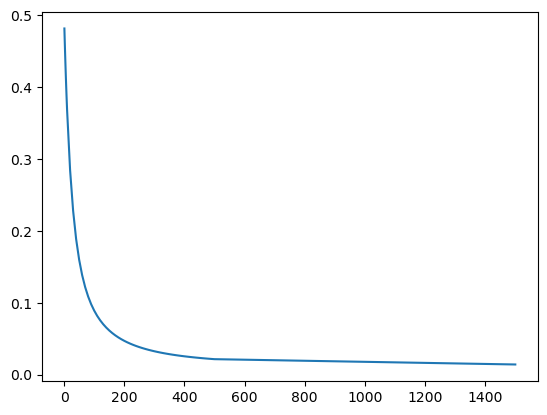

In [49]:
plt.plot(t_range,E_Sb2-E_Sw2)
# plt.semilogx(base=10)

#### Simulation + theory using ARG in a neutral admixture model

In [34]:
dir_parent = '/n/holyscratch01/mallet_lab/txiong/Research/2022_EntropyAncestry/simulation.slim/neutralWF'

# simulation scheme

N = 200
t = 2000

os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))

# N.200.t.2000
seeds = ['3622107279390','4079640997079','4082461082423','4083301133618','4083751181943']

# N.2000.t.2000
# seeds = ['2092003974471','2548164334100','2631954398878','3055964774913','4347313557608']


# sampling scheme

# L=10^4, nResampling = 1
# L=10^5, nResampling = 1
# L=10^6, nResampling = 10
# L=10^7, nResampling = 100

P = np.array([0.1,0.2,0.3,0.4])
nDiploid = 10
L = 1000000
nResampling = 10

parameters=[P,nDiploid,L,nResampling]

P_str = ','.join(P.astype(str))


100%|██████████| 74/74 [00:12<00:00,  6.02it/s]


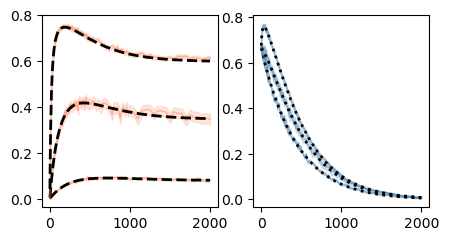

In [56]:
L_s = [10000,100000,1000000]
nResampling_s = [1,1,10]

fig, ax = plt.subplots(1,2,figsize=(5,2.5))

for i in range(len(L_s)):
    
    L = L_s[i]
    nResampling = nResampling_s[i]
    
    parameters=[P,nDiploid,L,nResampling]
    
    sim_results = get_simulation_results(N,t,seeds,parameters,dir_parent)
    Sb_mean,Sw_mean,Sb_ste,Sw_ste,E_Sb2,E_Sw2,t_range,gen_range = sim_results

    
    ax[1].plot(gen_range,Sb_mean,label=r'$S_b$',alpha=0.5,linewidth=1,color='steelblue')
    ax[0].plot(gen_range,Sw_mean,label=r'$S_w$',alpha=0.5,linewidth=1,color='coral')
    ax[1].fill_between(gen_range,Sb_mean+Sb_ste,Sb_mean-Sb_ste,alpha=.2,color='steelblue')
    ax[0].fill_between(gen_range,Sw_mean+Sw_ste,Sw_mean-Sw_ste,alpha=.2,color='coral')
    
    
    ax[1].plot(t_range+1,E_Sb2,linestyle='dotted',linewidth=2,color='black',
             label=r'$\mathbb{E}_{\mathsf{ARG}}[S_b]$')
    ax[0].plot(t_range+1,E_Sw2,linestyle='dashed',linewidth=2,color='black',
             label=r'$\mathbb{E}_{\mathsf{ARG}}[S_w]$')
    

In [ ]:
# N = 200
# t = 2000
# P = np.array([0.1,0.2,0.3,0.4])
# nDiploid = 10

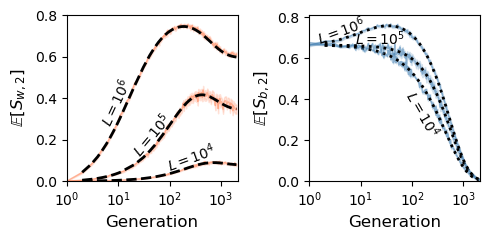

In [51]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

for k in np.arange(0,2):

    ax[k].set_ylim(bottom=0,)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


ax[0].annotate('$L=10^6$',(10**0.6,0.25),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.2,0.1),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**1.9,0.03),va='bottom',rotation=20)

ax[1].annotate('$L=10^6$',(10**0.1,0.65),va='bottom',rotation=20)
ax[1].annotate('$L=10^5$',(10**0.9,0.65),va='bottom',rotation=0)
ax[1].annotate('$L=10^4$',(10**1.8,0.2),va='bottom',rotation=-60)

    
fig.tight_layout()   

fig

In [52]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [32]:
# N = 2000
# t = 2000
# P = np.array([0.1,0.2,0.3,0.4])
# nDiploid = 10

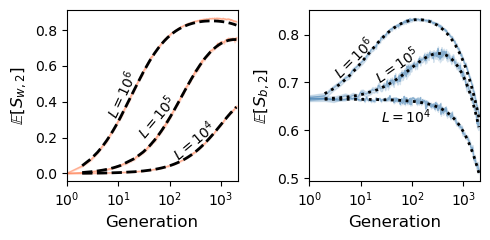

In [31]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

ax[0].annotate('$L=10^6$',(10**0.7,0.29),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.3,0.175),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**2.0,0.05),va='bottom',rotation=40)

ax[1].annotate('$L=10^6$',(10**0.4,0.7),va='bottom',rotation=45)
ax[1].annotate('$L=10^5$',(10**1.2,0.69),va='bottom',rotation=35)
ax[1].annotate('$L=10^4$',(10**1.4,0.61),va='bottom',rotation=0)

for k in np.arange(0,2):

    ax[k].set_ylim(auto=True)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


    
fig.tight_layout()   

fig

In [33]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [ ]:
# N = 200
# t = 2000
# P = np.array([0.5,0.5])
# nDiploid = 10

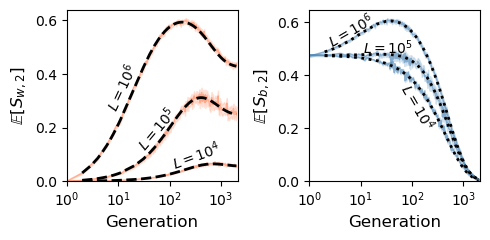

In [51]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

for k in np.arange(0,2):

    ax[k].set_ylim(bottom=0,)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


ax[0].annotate('$L=10^6$',(10**0.7,0.25),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.3,0.1),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**2.0,0.03),va='bottom',rotation=20)

ax[1].annotate('$L=10^6$',(10**0.3,0.49),va='bottom',rotation=30)
ax[1].annotate('$L=10^5$',(10**1.05,0.47),va='bottom',rotation=0)
ax[1].annotate('$L=10^4$',(10**1.7,0.18),va='bottom',rotation=-60)

    
fig.tight_layout()   

fig

In [52]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [ ]:
# N = 2000
# t = 2000
# P = np.array([0.5,0.5])
# nDiploid = 10

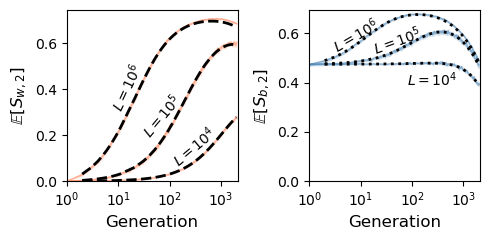

In [31]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

ax[0].annotate('$L=10^6$',(10**0.8,0.29),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.4,0.175),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**2.0,0.05),va='bottom',rotation=40)

ax[1].annotate('$L=10^6$',(10**0.4,0.51),va='bottom',rotation=30)
ax[1].annotate('$L=10^5$',(10**1.2,0.5),va='bottom',rotation=20)
ax[1].annotate('$L=10^4$',(10**1.9,0.375),va='bottom',rotation=0)

for k in np.arange(0,2):

    ax[k].set_ylim(bottom=0,)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


    
fig.tight_layout()   

fig

In [32]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [8]:
# N = 2000
# t = 2000
# P = np.array([0.5,0.5])
# nDiploid = 1

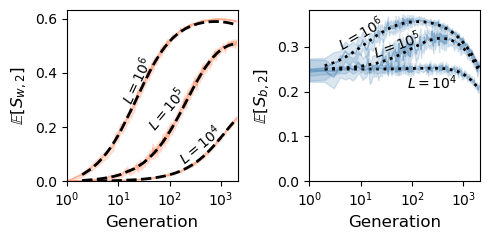

In [57]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

for k in np.arange(0,2):

    ax[k].set_ylim(bottom=0,)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


ax[0].annotate('$L=10^6$',(10**1,0.275),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.5,0.175),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**2.1,0.05),va='bottom',rotation=40)

ax[1].annotate('$L=10^6$',(10**0.5,0.285),va='bottom',rotation=30)
ax[1].annotate('$L=10^5$',(10**1.2,0.265),va='bottom',rotation=20)
ax[1].annotate('$L=10^4$',(10**1.9,0.2),va='bottom',rotation=0)

    
fig.tight_layout()   

fig

In [58]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

In [9]:
# N = 200
# t = 2000
# P = np.array([0.5,0.5])
# nDiploid = 1

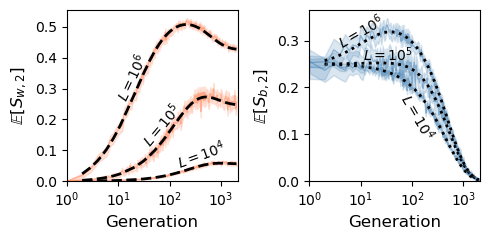

In [61]:
ax[1].set_ylabel(r'$\mathbb{E}[S_{b,2}]$',fontsize=12)
ax[0].set_ylabel(r'$\mathbb{E}[S_{w,2}]$',fontsize=12)

for k in np.arange(0,2):

    ax[k].set_ylim(bottom=0,)
    ax[k].set_xlim(1,)
    ax[k].semilogx(base=10)
    ax[k].set_xticks([1,10,100,1000])
    # ax[k].semilogy(base=10)


    ax[k].set_xlabel('Generation',fontsize=12)
    # ax[k].set_title('$\{p_k\}=$'+'({})'.format(P_str),fontsize=10)


ax[0].annotate('$L=10^6$',(10**0.9,0.25),va='bottom',rotation=65)
ax[0].annotate('$L=10^5$',(10**1.4,0.1),va='bottom',rotation=50)
ax[0].annotate('$L=10^4$',(10**2.1,0.03),va='bottom',rotation=20)

ax[1].annotate('$L=10^6$',(10**0.5,0.275),va='bottom',rotation=30)
ax[1].annotate('$L=10^5$',(10**1.05,0.25),va='bottom',rotation=0)
ax[1].annotate('$L=10^4$',(10**1.7,0.08),va='bottom',rotation=-60)

    
fig.tight_layout()   

fig

In [62]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'E_Sb2_Sw2_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png')
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

## 2. Unphased diploid analysis

In [2]:
import seaborn as sns

In [32]:
dir_parent = '/n/holyscratch01/mallet_lab/txiong/Research/2022_EntropyAncestry/simulation.slim/neutralWF'

# simulation scheme

N = 200
t = 2000

os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))

# N.200.t.2000
seeds = ['3622107279390','4079640997079','4082461082423','4083301133618','4083751181943']

# N.2000.t.2000
# seeds = ['2092003974471','2548164334100','2631954398878','3055964774913','4347313557608']


# sampling scheme

# L=10^4, nResampling = 1
# L=10^5, nResampling = 1
# L=10^6, nResampling = 10
# L=10^7, nResampling = 100

# P = np.array([0.5,0.5])
P = np.array([0.1,0.2,0.3,0.4])

nDiploid = 10
L = 10000
nResampling = 1

parameters=[P,nDiploid,L,nResampling]

P_str = ','.join(P.astype(str))

In [33]:
    
P,nDiploid,L,nResampling = parameters

os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))

P_str = ','.join(P.astype(str))


# enumerate over all seeds

Sw_hap_all = []
Sw_dip_all = []
Sb_hap_all = []
Sb_dip_all = []

for s in seeds:

    Sb = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sb2_HaploidvsDiploid_P_{}_nDiploid_{}_L_{}_nResampling_{}.npz'.format(s,P_str,nDiploid,L,nResampling),
        allow_pickle=True)
    Sw = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sw2_HaploidvsDiploid_P_{}_nDiploid_{}_L_{}_nResampling_{}.npz'.format(s,P_str,nDiploid,L,nResampling),
        allow_pickle=True)

    Sb_hap_dict = Sb['Sb_hap_dict'].item()
    Sb_dip_dict = Sb['Sb_dip_dict'].item()
    Sw_hap_dict = Sw['Sw_hap_dict'].item()
    Sw_dip_dict = Sw['Sw_dip_dict'].item()

    gen_range = [int((k.split(',')[0]).split('=')[1]) for k in Sb_hap_dict.keys()]

    Sw_hap = np.array([Sw_hap_dict['gen={},L={}'.format(gen,L)] for gen in gen_range]).flatten()
    Sw_dip = np.array([Sw_dip_dict['gen={},L={}'.format(gen,L)] for gen in gen_range]).flatten()
    Sb_hap = np.array([Sb_hap_dict['gen={},L={}'.format(gen,L)] for gen in gen_range]).flatten()
    Sb_dip = np.array([Sb_dip_dict['gen={},L={}'.format(gen,L)] for gen in gen_range]).flatten()

    Sw_hap_all.append(Sw_hap)
    Sb_hap_all.append(Sb_hap)
    Sw_dip_all.append(Sw_dip)
    Sb_dip_all.append(Sb_dip)
    

In [34]:
Sw_hap = np.concatenate(Sw_hap_all)
Sb_hap = np.concatenate(Sb_hap_all)
Sw_dip = np.concatenate(Sw_dip_all)
Sb_dip = np.concatenate(Sb_dip_all)


In [35]:
def S_dip_conditioning_on_S_hap(Sh,Sd,interval):
    
    idx = (Sh >= interval[0]) & (Sh < interval[1])
    
    if np.sum(idx)<=10:
        
        return np.nan,np.nan,np.nan
    
    else:
        
        x=np.quantile(Sd[idx],0.5,method='inverted_cdf')
        y=np.quantile(Sd[idx],0.25,method='inverted_cdf')
        z=np.quantile(Sd[idx],0.75,method='inverted_cdf')
    
        return x,y,z
    
    

In [36]:
dS = 0.025
interval_l = np.arange(0,1,dS)
interval_r = interval_l + dS
interval_mid = (interval_l + interval_r)/2

m_Sw_all = []
u_Sw_all = []
v_Sw_all = []
m_Sb_all = []
u_Sb_all = []
v_Sb_all = []

for i in range(len(interval_l)):
    
    m_Sw,u_Sw,v_Sw = S_dip_conditioning_on_S_hap(Sw_hap,Sw_dip,[interval_l[i],interval_r[i]])
    m_Sb,u_Sb,v_Sb = S_dip_conditioning_on_S_hap(Sb_hap,Sb_dip,[interval_l[i],interval_r[i]])
    
    m_Sw_all.append(m_Sw)
    u_Sw_all.append(u_Sw)
    v_Sw_all.append(v_Sw)
    m_Sb_all.append(m_Sb)
    u_Sb_all.append(u_Sb)
    v_Sb_all.append(v_Sb)

In [37]:
r_Sw = np.corrcoef(np.array([Sw_hap,Sw_dip]))[0,1]
r_Sb = np.corrcoef(np.array([Sb_hap,Sb_dip]))[0,1]

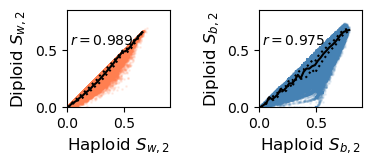

In [38]:
fig,ax = plt.subplots(1,2,figsize=(4,1.75))

ax[0].scatter(Sw_hap,Sw_dip,1,
           color='coral',
           alpha=0.1,
           )
ax[0].plot(interval_mid,m_Sw_all,color='black')
ax[0].plot(interval_mid,u_Sw_all,color='black',linestyle='dotted')
ax[0].plot(interval_mid,v_Sw_all,color='black',linestyle='dotted')

ax[0].set_xlabel('Haploid $S_{w,2}$',fontsize=12)
ax[0].set_ylabel('Diploid $S_{w,2}$',fontsize=12)
ax[0].set_aspect(1)
ax[0].annotate(r'$r={}$'.format(np.round(r_Sw,3)),(0.025,0.55))


ax[1].scatter(Sb_hap,Sb_dip,1,
           color='steelblue',
           alpha=0.1,
           )
ax[1].plot(interval_mid,m_Sb_all,color='black')
ax[1].plot(interval_mid,u_Sb_all,color='black',linestyle='dotted')
ax[1].plot(interval_mid,v_Sb_all,color='black',linestyle='dotted')

ax[1].set_xlabel('Haploid $S_{b,2}$',fontsize=12)
ax[1].set_ylabel('Diploid $S_{b,2}$',fontsize=12)
ax[1].set_aspect(1)
ax[1].annotate(r'$r={}$'.format(np.round(r_Sb,3)),(0.025,0.55))

ax[0].set_ylim(0,0.85)
ax[0].set_xlim(0,0.9)
ax[1].set_ylim(0,0.85)
ax[1].set_xlim(0,0.9)

# ax[0].plot([0,1],[0,1],color='black',linewidth=1,linestyle='dashed')
# ax[1].plot([0,1],[0,1],color='black',linewidth=1,linestyle='dashed')

fig.tight_layout()   
plt.show()

In [39]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/Simulation_SLiM/NeutralWF_output'

prefix = 'S_Hap.vs.Dip_N_{}_P_{}_nDiploid_{}_L_{}_dS_window_{}'.format(N,P_str,nDiploid,L,dS)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

## 3. Entropy diagrams

In [104]:
dir_parent = '/n/holyscratch01/mallet_lab/txiong/Research/2022_EntropyAncestry/simulation.slim/neutralWF'

# simulation scheme

N = 200
t = 2000

os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))

# N.200.t.2000
seeds = ['3622107279390','4079640997079','4082461082423','4083301133618','4083751181943']

# N.2000.t.2000
# seeds = ['2092003974471','2548164334100','2631954398878','3055964774913','4347313557608']


# sampling scheme

# L=10^4, nResampling = 1
# L=10^5, nResampling = 1
# L=10^6, nResampling = 10
# L=10^7, nResampling = 100

# P = np.array([0.5,0.5])
P = np.array([0.1,0.2,0.3,0.4])
H0 = 1-(P**2).sum()
J0 = 1-(P**3).sum()

nDiploid = 10
L = 1000000
nResampling = 1

parameters=[P,nDiploid,L,nResampling]

P_str = ','.join(P.astype(str))

#### The joint dynamics between $S_{w,2}$ and $S_{b,2}$

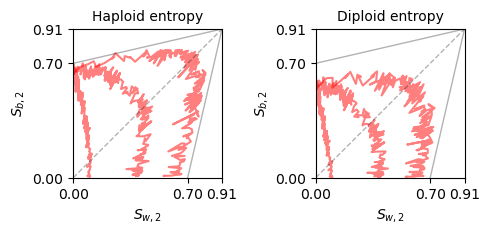

In [118]:
nDiploid = 10
L_all = [int(10**4),int(10**5),int(10**6)]
nResampling_all = [1,1,10]

fig,ax=plt.subplots(1,2,figsize=(5,2*1.25))


for L,nResampling in zip(L_all,nResampling_all):

    parameters=[P,nDiploid,L,nResampling]

    P_str = ','.join(P.astype(str))

    P,nDiploid,L,nResampling = parameters

    os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))

    P_str = ','.join(P.astype(str))


    # enumerate over all seeds

    Sw_hap_all = []
    Sw_dip_all = []
    Sb_hap_all = []
    Sb_dip_all = []

    for s in seeds:

        Sb = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sb2_HaploidvsDiploid_P_{}_nDiploid_{}_L_{}_nResampling_{}.npz'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True)
        Sw = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sw2_HaploidvsDiploid_P_{}_nDiploid_{}_L_{}_nResampling_{}.npz'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True)

        Sb_hap_dict = Sb['Sb_hap_dict'].item()
        Sb_dip_dict = Sb['Sb_dip_dict'].item()
        Sw_hap_dict = Sw['Sw_hap_dict'].item()
        Sw_dip_dict = Sw['Sw_dip_dict'].item()

        gen_range = [int((k.split(',')[0]).split('=')[1]) for k in Sb_hap_dict.keys()]

        Sw_hap = np.array([Sw_hap_dict['gen={},L={}'.format(gen,L)] for gen in gen_range])
        Sw_dip = np.array([Sw_dip_dict['gen={},L={}'.format(gen,L)] for gen in gen_range])
        Sb_hap = np.array([Sb_hap_dict['gen={},L={}'.format(gen,L)] for gen in gen_range])
        Sb_dip = np.array([Sb_dip_dict['gen={},L={}'.format(gen,L)] for gen in gen_range])

        Sw_hap_all.append(Sw_hap)
        Sb_hap_all.append(Sb_hap)
        Sw_dip_all.append(Sw_dip)
        Sb_dip_all.append(Sb_dip)
    
    seed_idx = 0
    nResampling_idx = 0
    
    x_hap = Sw_hap_all[seed_idx][:,nResampling_idx,:].mean(axis=1)
    y_hap = Sb_hap_all[seed_idx][:,nResampling_idx,:].mean(axis=1)
    x_dip = Sw_dip_all[seed_idx][:,nResampling_idx,:].mean(axis=1)
    y_dip = Sb_dip_all[seed_idx][:,nResampling_idx,:].mean(axis=1)
      
    ax[0].plot(x_hap,y_hap,alpha=0.5,color='red')
    ax[1].plot(x_dip,y_dip,alpha=0.5,color='red')
    
            
ax[0].set_xlim(0,H0*(2-H0))
ax[0].set_ylim(0,H0*(2-H0))
ax[0].set_aspect(1)
ax[0].set_xlabel(r'$S_{w,2}$')
ax[0].set_ylabel(r'$S_{b,2}$')  
ax[0].set_xticks([0,H0,H0*(2-H0)])
ax[0].set_yticks([0,H0,H0*(2-H0)])
ax[0].set_title('Haploid entropy',fontsize=10)  

ax[1].set_xlim(0,H0*(2-H0))
ax[1].set_ylim(0,H0*(2-H0))
ax[1].set_aspect(1)
ax[1].set_xlabel(r'$S_{w,2}$')
ax[1].set_ylabel(r'$S_{b,2}$')  
ax[1].set_xticks([0,H0,H0*(2-H0)])
ax[1].set_yticks([0,H0,H0*(2-H0)])
ax[1].set_title('Diploid entropy',fontsize=10)  

ax[0].plot([0,H0*(2-H0),H0],[H0,H0*(2-H0),0],color='black',linewidth=1,alpha=0.3)
ax[1].plot([0,H0*(2-H0),H0],[H0,H0*(2-H0),0],color='black',linewidth=1,alpha=0.3)
ax[0].plot([0,H0*(2-H0)],[0,H0*(2-H0)],color='black',linestyle='dashed',linewidth=1,alpha=0.3)
ax[1].plot([0,H0*(2-H0)],[0,H0*(2-H0)],color='black',linestyle='dashed',linewidth=1,alpha=0.3)

fig.tight_layout()

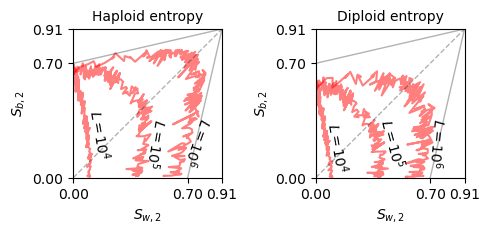

In [119]:
ax[0].annotate(r'$L=10^6$',(0.65,0.05),va='bottom',rotation=-110)
ax[0].annotate(r'$L=10^5$',(0.425,0.05),va='bottom',rotation=-100)
ax[0].annotate(r'$L=10^4$',(0.075,0.1),va='bottom',rotation=-80)

ax[1].annotate(r'$L=10^6$',(0.675,0.05),va='bottom',rotation=-95)
ax[1].annotate(r'$L=10^5$',(0.375,0.05),va='bottom',rotation=-75)
ax[1].annotate(r'$L=10^4$',(0.05,0.025),va='bottom',rotation=-80)

fig

In [2]:
def Generator(N,r):
    # the generator of a two-locus, two-haplotype ARG
    R = 2*N*r
    G1 = np.array([[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,0,0,0,0],
              [R,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [R,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,R,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,R,0,0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,R,R,R,R,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,1,0,0,0,1,0,0,0,0,0],
              [0,0,0,1,1,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,1,R,R,0,0,0,0,0,0],
              [0,0,1,0,1,0,0,0,0,0,0,0,1,0,0],
              [0,0,0,1,0,1,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,1,0,0,0,R,R,0,0,0],
              [1,1,0,0,0,0,0,1,1,0,1,1,0,0,1],
              [0,0,0,0,0,0,0,0,0,1,0,0,1,R,0]])/(2*N)
    G2 = np.diag([-2*R-1,-2*R-1,-R-3,-R-3,-R-3,
                  -R-3,-6,-R-1,-R-1,-3,-R-1,
                  -R-1,-3,-R,-1])/(2*N)
    
    return G1 + G2

def Qb_bar(t,α1,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    Gs = np.array([np.transpose(Generator(N,1-np.exp(-abs(x-y)))) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return np.matmul((expm(t*Gs).mean(axis=0)),α1)[0]

def Qw_bar(t,α2,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    Gs = np.array([np.transpose(Generator(N,1-np.exp(-abs(x-y)))) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return np.matmul((expm(t*Gs).mean(axis=0)),α2)[0]

def qw(t,H0,r,N):
    
    p = (1+2*N*r*np.exp(-t/(2*N)-r*t))/(1+2*N*r) 
    return (1-p)*(1-H0) + p

def qw_bar(t,H0,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    qws = np.array([qw(t,H0,1-np.exp(-abs(x-y)),N) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return qws.mean()

def qc(t,H0,r,N):
    
    p = 1-H0*(np.exp(-t/(2*N)-r*t)+2*N*r)/(1+2*N*r)
    return p

def Qc_bar(t,H0,l,N):
    
    # Note: l is: the probability of nearest neighbor recombination * L
    
    M = 30
    qcs = np.array([qc(t,H0,1-np.exp(-abs(x-y)),N) for x in np.arange(0,l,l/M) for y in np.arange(0,l,l/M)])
    
    return qcs.mean()


def get_simulation_results(N,t,seeds,parameters,dir_parent):
    
    P,nDiploid,L,nResampling = parameters
    
    os.chdir('{}/N.{}.t.{}'.format(dir_parent,N,t))
    
    P_str = ','.join(P.astype(str))

    # two probability vectors

    H0 = 1 - np.sum(P**2)
    J0 = 1 - np.sum(P**3)

    α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
    α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])
    
    # enumerate over all seeds

    Sw_mean_all = []
    Sw_ste_all = []
    Sb_mean_all = []
    Sb_ste_all = []

    for s in tqdm(seeds):

        Sb = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sb2_P_{}_nDiploid_{}_L_{}_nResampling_{}.npy'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True).item()
        Sw = np.load('{}/N.{}.t.{}'.format(dir_parent,N,t)+'/slim_seed{}/Entropy_Sw2_P_{}_nDiploid_{}_L_{}_nResampling_{}.npy'.format(s,P_str,nDiploid,L,nResampling),
            allow_pickle=True).item()

        gen_range = [int((k.split(',')[0]).split('=')[1]) for k in Sb.keys()]

        Sw_mean = np.array([np.mean(Sw['gen={},L={}'.format(gen,L)]) for gen in gen_range])
        Sb_mean = np.array([np.mean(Sb['gen={},L={}'.format(gen,L)]) for gen in gen_range])

        Sw_ste = np.array([np.std(Sw['gen={},L={}'.format(gen,L)])/np.sqrt(np.array(Sw['gen={},L={}'.format(gen,L)]).size) for gen in gen_range])
        Sb_ste = np.array([np.std(Sb['gen={},L={}'.format(gen,L)])/np.sqrt(np.array(Sb['gen={},L={}'.format(gen,L)]).size) for gen in gen_range])

        Sw_mean_all.append(Sw_mean)
        Sb_mean_all.append(Sb_mean)
        Sw_ste_all.append(Sw_ste)
        Sb_ste_all.append(Sb_ste)
    
    
    Sw_mean = np.array(Sw_mean_all).mean(axis=0)
    Sb_mean = np.array(Sb_mean_all).mean(axis=0)

    Sw_ste = np.sqrt((np.array(Sw_ste_all)**2).sum(axis=0)/len(Sw_ste_all))
    Sb_ste = np.sqrt((np.array(Sb_ste_all)**2).sum(axis=0)/len(Sw_ste_all))
    
    
    # calculate theoretical curves from ARG
    
    l = L/1e7

    t_range = np.concatenate([np.arange(1,10,1),np.arange(10,500,10),np.arange(500,t+100,100)])


    Qb_bar_eval = np.array([])
    Qw_bar_eval = np.array([])
    qw_bar_eval = np.array([])

    for t in tqdm(t_range):
        Qb_bar_eval = np.append(Qb_bar_eval,Qb_bar(t,α1,l,N))
        Qw_bar_eval = np.append(Qw_bar_eval,Qw_bar(t,α2,l,N))
        qw_bar_eval = np.append(qw_bar_eval,qw_bar(t,H0,l,N))
    
    n = nDiploid * 2

    E_Sb2 = 1 - (n-1)/n * Qb_bar_eval - 1/n
    E_Sw2 = 1 - (n-1)/n * Qw_bar_eval - 1/n * qw_bar_eval
    
    
    return Sb_mean,Sw_mean,Sb_ste,Sw_ste,E_Sb2,E_Sw2,t_range,gen_range

In [3]:
# calculate theoretical curves from ARG
def get_ESb2_ESw2_ESf2(N,L,P):
    
    P = P # P must be a numpy array

    nDiploid = 50
    L = L
    N = N
    t = 20000

    l = L/1e7
    H0 = 1 - np.sum(P**2)
    J0 = 1 - np.sum(P**3)

    α1 = np.array([1-H0,1-H0,1-J0,1-J0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-H0,1-H0,1-H0,1-H0,1,1])
    α2 = np.array([1,1-H0,1-H0,1-H0,1-J0,1-J0,(1-H0)**2,1-H0,1-H0,1-J0,1-H0,1-H0,1-J0,1,1-H0])


    t_range = np.concatenate([np.arange(1,10,1),
                              np.arange(10,100,5),
                              np.arange(100,1000,50),
                              np.arange(1000,10000,500),
                              np.arange(10000,100000,5000)])


    Qb_bar_eval = np.array([])
    Qw_bar_eval = np.array([])
    qw_bar_eval = np.array([])
    Qc_bar_eval = np.array([])

    for t in tqdm(t_range):
        Qb_bar_eval = np.append(Qb_bar_eval,Qb_bar(t,α1,l,N))
        Qw_bar_eval = np.append(Qw_bar_eval,Qw_bar(t,α2,l,N))
        qw_bar_eval = np.append(qw_bar_eval,qw_bar(t,H0,l,N))
        Qc_bar_eval = np.append(Qc_bar_eval,Qc_bar(t,H0,l,N))

    n = nDiploid * 2

    E_Sb2 = 1 - (n-1)/n * Qb_bar_eval - 1/n
    E_Sw2 = 1 - (n-1)/n * Qw_bar_eval - 1/n * qw_bar_eval
    E_Sf2 = 1 - (n-1)/n * Qc_bar_eval - 1/n * qw_bar_eval
    
    return E_Sb2,E_Sw2,E_Sf2,t_range

In [4]:
N = 2000
P = np.array([0.1,0.2,0.3,0.4])

# for incremental L
dL = 0.5

np.arange(2,7+dL,dL)
L_range = np.round(10**np.arange(2,7+dL,dL)).astype(int)

# for extreme L
# L_range = [100,10000000]

ESb2_all = []
ESw2_all = []
ESf2_all = []
T_all = []

for L in L_range:
    
    print(L)
    
    ESb2,ESw2,ESf2,T = get_ESb2_ESw2_ESf2(N,L,P)
    
    ESb2_all.append(ESb2)
    ESw2_all.append(ESw2)
    ESf2_all.append(ESf2)
    T_all.append(T)

100


100%|██████████| 81/81 [00:12<00:00,  6.54it/s]


316


100%|██████████| 81/81 [00:13<00:00,  6.20it/s]


1000


100%|██████████| 81/81 [00:12<00:00,  6.60it/s]


3162


100%|██████████| 81/81 [00:12<00:00,  6.56it/s]


10000


100%|██████████| 81/81 [00:13<00:00,  6.17it/s]


31623


100%|██████████| 81/81 [00:12<00:00,  6.42it/s]


100000


100%|██████████| 81/81 [00:12<00:00,  6.34it/s]


316228


100%|██████████| 81/81 [00:14<00:00,  5.63it/s]


1000000


100%|██████████| 81/81 [00:14<00:00,  5.63it/s]


3162278


100%|██████████| 81/81 [00:15<00:00,  5.30it/s]


10000000


100%|██████████| 81/81 [00:15<00:00,  5.31it/s]


1000
3162
10000
31623
100000
1000000


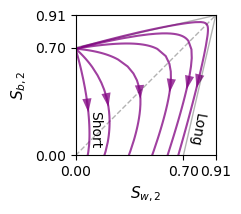

In [62]:
H0 = 1-(P**2).sum()
J0 = 1-(P**3).sum()

fig,ax=plt.subplots(1,1,figsize=(2.5,2.5))

ax.set_xlim(0,H0*(2-H0))
ax.set_ylim(0,H0*(2-H0))
ax.set_aspect(1)
ax.set_xlabel(r'$S_{w,2}$',fontsize=11)
ax.set_ylabel(r'$S_{b,2}$',fontsize=11)  
ax.set_xticks([0,H0,H0*(2-H0)])
ax.set_yticks([0,H0,H0*(2-H0)])
# ax.set_title('Diagram 1',fontsize=11)

ax.plot([0,H0*(2-H0),H0],[H0,H0*(2-H0),0],color='black',linewidth=1,alpha=0.3)
ax.plot([0,H0*(2-H0)],[0,H0*(2-H0)],color='black',linestyle='dashed',linewidth=1,alpha=0.3)

Ls = len(L_range)

for i in [2,
          3,
          int(np.ceil(Ls/2))-2,
          5,
          6,
          Ls-3]:
    
    print(L_range[i])

    ax.plot(ESw2_all[i],ESb2_all[i],color='purple',alpha=0.75)
    
    # k = 26
    # ax.arrow(ESw2_all[i][k],ESb2_all[i][k],
    #          ESw2_all[i][k+1]-ESw2_all[i][k],
    #          ESb2_all[i][k+1]-ESb2_all[i][k],
    #          shape='full', lw=0, length_includes_head=True, head_width=0.05,
    #          color='purple')
    
    k = 50
    ax.arrow(ESw2_all[i][k],ESb2_all[i][k],
             ESw2_all[i][k+1]-ESw2_all[i][k],
             ESb2_all[i][k+1]-ESb2_all[i][k],
             shape='full', lw=0, length_includes_head=True, head_width=0.06,
             color='purple',alpha=0.75)

ax.annotate('Short',(0.08,0.05),va='bottom',rotation=-90)
ax.annotate('Long',(0.725,0.05),va='bottom',rotation=-100)


fig.tight_layout()

In [63]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/PhaseDiagram'

P_str = '0.1,0.2,0.3,0.4'
N = 2000
nDiploid = 50

prefix = 'PhaseDiagram_Type1_ARG_HapS_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

#### The joint dynamics between $S_{f,2}$ and $\Delta S$

1000
3162
10000
31623
100000
1000000


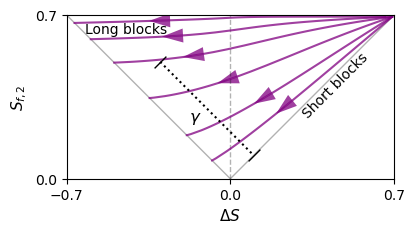

In [54]:
H0 = 1-(P**2).sum()
J0 = 1-(P**3).sum()

fig,ax=plt.subplots(1,1,figsize=(4.25,2.5))

ax.set_ylim(0,H0)
ax.set_xlim(-H0,H0)
ax.set_aspect(1)
ax.set_ylabel(r'$S_{f,2}$',fontsize=11)
ax.set_xlabel(r'$\Delta S$',fontsize=11)  
ax.set_yticks([0,H0])
ax.set_xticks([-H0,0,H0])
# ax.set_title('',fontsize=11)

ax.plot([H0,0,-H0],[H0,0,H0],color='black',linewidth=1,alpha=0.3)
ax.plot([0,0],[0,H0],color='black',linestyle='dashed',linewidth=1,alpha=0.3)

Ls = len(L_range)

for i in [2,
          3,
          int(np.ceil(Ls/2))-2,
          5,
          6,
          Ls-3]:
    
    print(L_range[i])

    ax.plot(ESb2_all[i]-ESw2_all[i],
            ESf2_all[i],
            color='purple',alpha=0.75)
    
    # k = 26
    # ax.arrow(ESw2_all[i][k],ESb2_all[i][k],
    #          ESw2_all[i][k+1]-ESw2_all[i][k],
    #          ESb2_all[i][k+1]-ESb2_all[i][k],
    #          shape='full', lw=0, length_includes_head=True, head_width=0.05,
    #          color='purple')
    
    k = 50
    ax.arrow((ESb2_all[i]-ESw2_all[i])[k],
             ESf2_all[i][k],
             (ESb2_all[i]-ESw2_all[i])[k+1]-(ESb2_all[i]-ESw2_all[i])[k],
             ESf2_all[i][k+1]-ESf2_all[i][k],
             shape='full', lw=0, length_includes_head=True, head_width=0.06,
             color='purple',alpha=0.75)

ax.annotate('Long blocks',(-0.62,0.61),va='bottom',rotation=0)
ax.annotate('Short blocks',(0.3,0.25),va='bottom',rotation=45)

ax.plot([-0.3,0.1],[0.5,0.1],
        marker=(2, 0, -45),
        markersize=12,
        color='black',linestyle='dotted',)
ax.annotate(r'$\gamma$',(-0.175,0.225),va='bottom',rotation=0,color="black",fontsize=12)

fig.tight_layout()

In [55]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/PhaseDiagram'

P_str = '0.1,0.2,0.3,0.4'
N = 2000
nDiploid = 50

prefix = 'PhaseDiagram_Type2_ARG_HapS_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

#### Dynamics of $\Delta S/S_{f,2}$

100
10000000


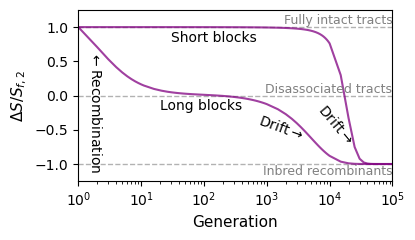

In [173]:
H0 = 1-(P**2).sum()
J0 = 1-(P**3).sum()

fig,ax=plt.subplots(1,1,figsize=(4.25,2.5))

ax.set_ylim(-1.25,1.25)
ax.set_xlim(1,100000)
# ax.set_aspect(1)
ax.set_ylabel(r'$\Delta S/S_{f,2}$',fontsize=11)
ax.set_xlabel('Generation',fontsize=11)  
# ax.set_yticks([0,H0])
# ax.set_xticks([-H0,0,H0])
# ax.set_title('',fontsize=11)

# ax.plot([H0,0,-H0],[H0,0,H0],color='black',linewidth=1,alpha=0.3)
ax.axhline(0,color='black',linestyle='dashed',linewidth=1,alpha=0.3)
ax.axhline(1,color='black',linestyle='dashed',linewidth=1,alpha=0.3)
ax.axhline(-1,color='black',linestyle='dashed',linewidth=1,alpha=0.3)

Ls = len(L_range)

for i in [0,
          Ls-1]:
    
    print(L_range[i])
    
    T = np.concatenate([np.array([1]),T_all[i]+1])
    Y = (ESb2_all[i]-ESw2_all[i])/ESf2_all[i]
    Y = np.concatenate([[H0/H0],Y])
    ax.plot(T,Y,
            color='purple',alpha=0.75)
    
ax.annotate('Long blocks',(20,-0.05),va='top',rotation=-0)
ax.annotate('Short blocks',(30,0.95),va='top',rotation=0)

ax.annotate(r'$\leftarrow$Recombination',(1.4,0.65),va='top',rotation=-90)


ax.annotate(r'Drift$\rightarrow$',(700,-0.25),va='top',rotation=-20)
ax.annotate(r'Drift$\rightarrow$',(6000,-0.1),va='top',rotation=-50)

ax.annotate(r'Fully intact tracts',(1e5,1),va='bottom',ha='right',
            color='gray',rotation=-0,fontsize=9)
ax.annotate(r'Disassociated tracts',(1e5,0),va='bottom',ha='right',
            color='gray',rotation=-0,fontsize=9)
ax.annotate(r'Inbred recombinants',(1e5,-1.02),va='top',ha='right',
            color='gray',rotation=-0,fontsize=9)




ax.set_xscale('log')

fig.tight_layout()

In [174]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/PhaseDiagram'

P_str = '0.1,0.2,0.3,0.4'
N = 2000
nDiploid = 50

prefix = 'PhaseDiagram_Type2_DeltaSoverSf_ARG_HapS_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

#### Dynamics of $\gamma$

100
10000000


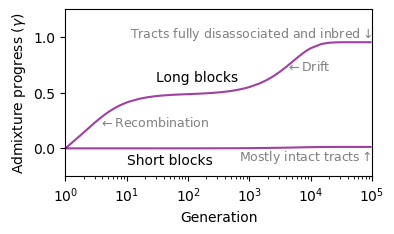

In [14]:
H0 = 1-(P**2).sum()
J0 = 1-(P**3).sum()

fig,ax=plt.subplots(1,1,figsize=(4.25,2.5))

ax.set_ylim(-0.25,1.25)
ax.set_xlim(1,100000)
# ax.set_aspect(1)
ax.set_ylabel('Admixture progress'+r' $(\gamma)$')
ax.set_xlabel('Generation')  
# ax.set_yticks([0,H0])
# ax.set_xticks([-H0,0,H0])
# ax.set_title('',fontsize=11)

# ax.plot([H0,0,-H0],[H0,0,H0],color='black',linewidth=1,alpha=0.3)
# ax.axhline(0,color='black',linestyle='dashed',linewidth=1,alpha=0.3)
# ax.axhline(1,color='black',linestyle='dashed',linewidth=1,alpha=0.3)

Ls = len(L_range)

Ls = len(L_range)

for i in [0,
          Ls-1]:
    
    print(L_range[i])
    
    T = np.concatenate([np.array([1]),T_all[i]+1])
    Y = (abs(ESf2_all[i]-(ESb2_all[i]-ESw2_all[i]))/np.sqrt(2))
    Y = np.concatenate([[0],Y])
    ax.plot(T,Y,
            color='purple',alpha=0.75)
    
ax.annotate('Short blocks',(10,-0.05),va='top',rotation=-0)
ax.annotate('Long blocks',(30,0.7),va='top',rotation=0)

ax.annotate(r'$\leftarrow$Recombination',(3.5,0.3),va='top',rotation=-0,color='gray',fontsize=9)


ax.annotate(r'$\leftarrow$Drift',(4000,0.8),va='top',rotation=-0,color='gray',fontsize=9)

ax.annotate(r'Tracts fully disassociated and inbred$\downarrow$',(1e5,0.95),va='bottom',ha='right',
            color='gray',rotation=-0,fontsize=9)
ax.annotate(r'Mostly intact tracts$\uparrow$',(1e5,-0.15),va='bottom',ha='right',
            color='gray',rotation=-0,fontsize=9)




ax.set_xscale('log')

fig.tight_layout()

In [15]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/PhaseDiagram'

P_str = '0.1,0.2,0.3,0.4'
N = 2000
nDiploid = 50

prefix = 'PhaseDiagram_Type2_AdmixProgress_ARG_HapS_N_{}_P_{}_nDiploid_{}'.format(N,P_str,nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

# The *P. maackii* hybrid zone

In [122]:
# source for ELAI estimated ancestry

# using the first version ref genome
# dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2019_Achillides_Sequencing/03_call.bcftools/vcfs.Pmaackii/output"

# using the corrected ref genome
dir_source = "/n/holyscratch01/mallet_lab/txiong/Research/2019_Achillides_Sequencing/03.1_call.bcftools/vcfs.Pmaackii/bimbams/output"

# parameters

gen = 5000
chrom = 29
run = 1

file_anc = "elai_output.gen{}.admx2.chr.{}.run.{}.ps21.txt".format(gen,chrom,run)
file_pos = "elai_output.gen{}.admx2.chr.{}.run.{}.snpinfo.txt".format(gen,chrom,run)


In [123]:
anc = np.loadtxt(dir_source+'/'+file_anc)
anc = anc[:,np.arange(0,np.shape(anc)[1],2)]
pos = pd.read_csv(dir_source+'/'+file_pos,sep='\t')
pos = np.array(pos[' pos '])

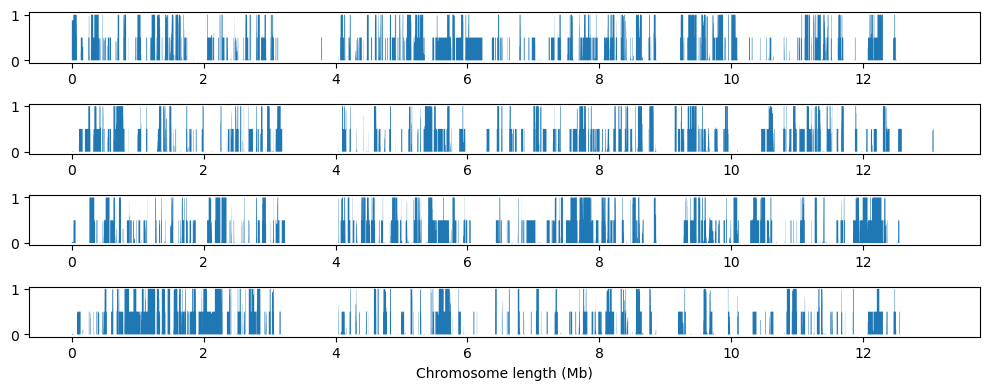

In [124]:
fig,ax= plt.subplots(4,1,figsize=(10,4))
for i in np.arange(0,4):
    # ax[i].plot(pos/1e6,anc[i,:],drawstyle="steps")
    ax[i].fill_between(pos/1e6,anc[i,:],)

ax[-1].set_xlabel('Chromosome length (Mb)')
fig.tight_layout()

In [125]:

dir_output = "/n/home00/txiong/Research/2022_EntropyAncestry/ReAnalysis/PmaackiiHybridZone/EstimatedAncestry"

prefix = 'ELAI.output.gen_parameter.{}.chr.{}.run.{}'.format(gen,chrom,run)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
# fig.savefig(filename+'.pdf')
# fig.savefig(filename+'.svg')


In [126]:
def vectorize_estimated_ancestry(anc):
    
    n,L = anc.shape
    
    anc_vec = np.zeros([2*n,L])
    
    for i in np.arange(0,2*n,2):
        
        anc_vec[i,:] = np.sqrt(anc[int(i/2),:])
        anc_vec[i+1,:] = np.sqrt(1-anc[int(i/2),:])
        
    return anc_vec

def get_Sb2_from_anc_vec(anc_vec,K):
    
    n_seps,L = anc_vec.shape
    
    n_dips = int(n_seps/K)
    
    cij = []
    
    for i in np.arange(0,n_seps,K):        
        for j in np.arange(i+2,n_seps,K):       
            cij.append(np.mean(anc_vec[i,:] * anc_vec[j,:] + anc_vec[i+1,:] * anc_vec[j+1,:]))
    
    cij = np.array(cij)
    
    return 1-(2*np.sum(cij**2) + n_dips)/(n_dips**2)


def get_Sw2_from_anc_vec(anc_vec,K):
    
    n_seps,L = anc_vec.shape
    
    n_dips = int(n_seps/K)
    
    cij = []
    
    for i in np.arange(0,n_seps,1):      
        for j in np.arange(i+1,n_seps,1):
            cij.append(np.mean(anc_vec[i,:] * anc_vec[j,:]))
            
    cii = []
    
    for i in np.arange(0,n_seps,1):
        cii.append(np.mean(anc_vec[i,:]**2))
            
    cij = np.array(cij)
    cii = np.array(cii)
    
    return 1 - (2*np.sum(cij**2) + np.sum(cii**2))/((n_dips)**2)
    
def get_Sf2_from_anc_vec(anc_vec,K):
    
    n_seps,L = anc_vec.shape
    
    n_dips = int(n_seps/K)
    
    p = []
    
    for k in np.arange(0,K):
        
        y = anc_vec[np.arange(0,n_seps,K)+k,:]
        p.append(np.mean(y**2))
        
    p = np.array(p)
    
    return 1-np.sum(p**2)

In [127]:
# parameters

gen = 5000

Sb2_all_dict = dict()
Sw2_all_dict = dict()
Sf2_all_dict = dict()

for run in np.arange(1,51):
    
    print(run)

    Sb2_all = []
    Sw2_all = []
    Sf2_all = []

    for chrom in tqdm(np.arange(1,31,1)):

        file_anc = "elai_output.gen{}.admx2.chr.{}.run.{}.ps21.txt".format(gen,chrom,run)
        file_pos = "elai_output.gen{}.admx2.chr.{}.run.{}.snpinfo.txt".format(gen,chrom,run)

        anc = np.loadtxt(dir_source+'/'+file_anc)
        anc = anc[:,np.arange(0,np.shape(anc)[1],2)]
        pos = pd.read_csv(dir_source+'/'+file_pos,sep='\t')
        pos = np.array(pos[' pos '])

        anc_vec = vectorize_estimated_ancestry(anc)

        Sb2 = get_Sb2_from_anc_vec(anc_vec,2)
        Sw2 = get_Sw2_from_anc_vec(anc_vec,2)
        Sf2 = get_Sf2_from_anc_vec(anc_vec,2)

        Sb2_all.append(Sb2)
        Sw2_all.append(Sw2)
        Sf2_all.append(Sf2)
        
        Sb2_all_dict["{}".format(run)] = Sb2_all
        Sw2_all_dict["{}".format(run)] = Sw2_all
        Sf2_all_dict["{}".format(run)] = Sf2_all

1


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


2


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


3


100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


4


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


5


100%|██████████| 30/30 [00:25<00:00,  1.15it/s]


6


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


7


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


8


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


9


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


10


100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


11


100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


12


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


13


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


14


100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


15


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


16


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


17


100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


18


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


19


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


20


100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


21


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


22


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


23


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


24


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


25


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


26


100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


27


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


28


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


29


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


30


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


31


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


32


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


33


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


34


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


35


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


36


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


37


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


38


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


39


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


40


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


41


100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


42


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


43


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


44


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


45


100%|██████████| 30/30 [00:25<00:00,  1.15it/s]


46


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


47


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


48


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


49


100%|██████████| 30/30 [00:26<00:00,  1.11it/s]


50


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


In [128]:
p=np.array([0.5,0.5])
H0=1-np.sum(p**2)

Sb2 = np.array([Sb2_all_dict[str(run)] for run in np.arange(1,51)])
Sw2 = np.array([Sw2_all_dict[str(run)] for run in np.arange(1,51)])
Sf2 = np.array([Sf2_all_dict[str(run)] for run in np.arange(1,51)])
    

In [129]:
ΔS = Sb2 - Sw2
γ = (abs(ΔS-Sf2)/np.sqrt(2))#/(np.sqrt(2)*H0)

ΔS_mean = np.mean(ΔS,axis=0)
γ_mean = np.mean(γ,axis=0)

ΔS_std = np.std(ΔS,axis=0)
γ_std = np.std(γ,axis=0)

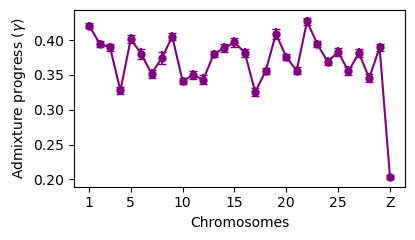

In [130]:
p=np.array([0.5,0.5])
H0=1-np.sum(p**2)

fig,ax = plt.subplots(figsize=(4.25,2.5))

ax.plot(np.arange(1,31),γ_mean,
         color='purple',
         # linewidth=1,
         markersize=5,
         marker='o')
ax.set_xticks(ticks=[1,5,10,15,20,25,30],labels=["1","5","10","15","20","25","Z"])
ax.set_xlabel("Chromosomes")
ax.set_ylabel("Admixture progress "+r"$(\gamma)$")
for i in np.arange(1,31):
    
    ax.plot([i,i],[γ_mean[i-1]+γ_std[i-1],γ_mean[i-1]-γ_std[i-1]],
             color='purple',
             marker='_')

fig.tight_layout()

In [29]:
# save fig

dir_output = '/n/home00/txiong/Research/2022_EntropyAncestry/ReAnalysis/PmaackiiHybridZone'

nDiploid = 4

prefix = 'PhaseDiagram_Type2_AdmixProgress_DipS_nDiploid_{}'.format(nDiploid)

filename = dir_output + '/' + prefix

fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.pdf')
fig.savefig(filename+'.svg')

#### Exploring the relationship between $\gamma$ and autosome size

In [161]:
# get CO frequency from bianor X dehaanii crosses

df = pd.read_csv('/n/home00/txiong/Research/2022_EntropyAncestry/CO_freq.csv',sep=',')

mean_CO = np.mean(np.array(df)[:,1:4] * np.array([0,1,2]),axis=1)

# get chromosome size

chr_size = np.loadtxt("/n/home00/txiong/chr_size.txt")

# bp per CO

size_per_CO = chr_size/mean_CO

size_per_CO

In [172]:
# regression

A = np.vstack([chr_size[:-1], np.ones(len(chr_size[:-1]))]).T
y = γ_mean[:-1]
m, c = np.linalg.lstsq(A, y, rcond=None)[0]


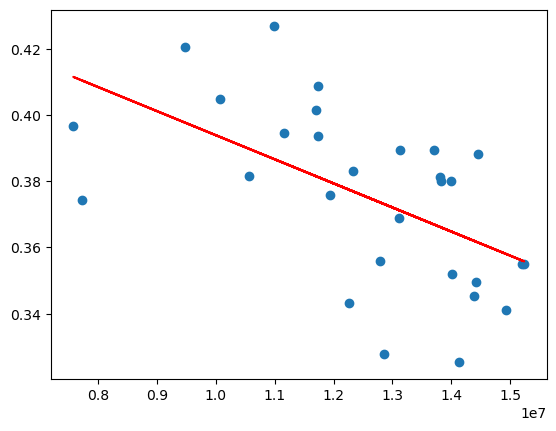

In [173]:
plt.scatter(chr_size[:-1],γ_mean[:-1])
plt.plot(chr_size[:-1], m*chr_size[:-1] + c, 'r', label='Fitted line')